# Multi-label Legal Text Classification for CIA

## Model Evaluation

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import csv
import gzip
import random

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, precision_score, recall_score, classification_report, confusion_matrix

In [3]:
from sentence_transformers import models, losses, datasets
from sentence_transformers import LoggingHandler, SentenceTransformer, util, InputExample
from sentence_transformers.evaluation import EmbeddingSimilarityEvaluator
from sentence_transformers.datasets import DenoisingAutoEncoderDataset
import torch
from torch.optim import Adam
from torch.utils.data import DataLoader
from tqdm import tqdm
import math
import logging
from datetime import datetime

/Users/janinedevera/opt/miniconda3/envs/mtc-models/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
os.chdir("/Users/janinedevera/Documents/School/MDS 2021-2023/Thesis/multilabel-legal-text-classification-CIA")
os.getcwd()

'/Users/janinedevera/Documents/School/MDS 2021-2023/Thesis/multilabel-legal-text-classification-CIA'

Prepare test data

In [7]:
# definitions
oecd_defs = pd.read_csv("data/02 oecd_definitions_stopwords_grouped.csv", index_col=0)

# sample test data
test_data = pd.read_csv("data/01 train_data_augmented.csv", index_col=0).drop_duplicates()

In [16]:
oecd_defs['Category_New'] = oecd_defs['Main'].replace('D', 'Others')
oecd_defs

,Main,text_clean,length,Category_New
0,A,limit the number of supplier lead to the risk ...,833,A
1,B,regul can affect a supplier 's abil to compet ...,781,B
2,C,regul can affect supplier behaviour by not onl...,459,C
3,D,regul sometim limit choic avail to consum for ...,257,Others


Similarity scores

In [8]:
def calculate_sim_scores(list1, list2, defs_name, labels_true, model): 
    
    df = pd.DataFrame(columns = ['Text', 'Label_Text', 'Label_Name', 'Score', 'Label_True'])
    
    for i, label in zip(list1, labels_true):
        embeddings1 = model.encode(i, convert_to_tensor = True)
        for j, name in zip(list2, defs_name):
            embeddings2 = model.encode(j, convert_to_tensor = True)
            cosine_scores = util.cos_sim(embeddings1, embeddings2)

            row = pd.DataFrame({'Text': i, 'Label_Text': j, 'Label_Name': name, 'Label_True': label, 'Score': cosine_scores[0]}, index=[0])
            df = pd.concat([row,df.loc[:]]).reset_index(drop=True)

    return df

In [18]:
test_list = test_data['text_clean'] 
labels_list = test_data['Category_New']
defs_list = oecd_defs['text_clean']
defs_name = oecd_defs['Category_New']

### A. BERT base + TSDAE + STS

In [20]:
# specify trained model 
model_sbert_sts = SentenceTransformer('models/sbert_stsbenchmark-2023-03-23_09-50')
model_tsdae = SentenceTransformer('models/tsdae-2023-03-22_12-39')

In [21]:
results = calculate_sim_scores(test_list, defs_list, defs_name, labels_list, model_sbert_sts).drop_duplicates()

In [22]:
results.to_csv("data/scores/03 sim_scores_bert_sts.csv")

Threshold based predictions

In [24]:
results = pd.read_csv("data/scores/03 sim_scores_bert_sts.csv", index_col = 0)

In [35]:
results_multiclass = results
results_multiclass['Predict'] = np.where(results_multiclass['Score'] > 0.65, results_multiclass['Label_Name'], 'None')

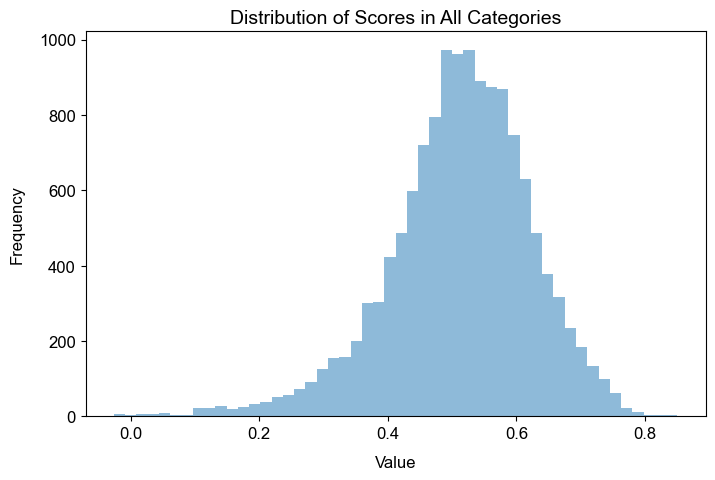

In [36]:
plt.figure(figsize=(8, 5))
plt.hist(results_multiclass['Score'], bins=50, alpha=0.5, fill='#0C6291')
plt.xlabel('Value', fontname='Arial', fontsize=12, labelpad=10)
plt.ylabel('Frequency', fontname='Arial', fontsize=12, labelpad=10)
plt.title('Distribution of Scores in All Categories', fontname='Arial', fontsize=14)
plt.xticks(fontname='Arial', fontsize=12)
plt.yticks(fontname='Arial', fontsize=12)
plt.show()

In [37]:
results_multiclass

,Text,Label_Text,Label_Name,Label_True,Score,Predict
0,• articl of the act stipul that the violat of ...,regul sometim limit choic avail to consum for ...,Others,B,0.620997,None
1,• articl of the act stipul that the violat of ...,regul can affect supplier behaviour by not onl...,C,B,0.599725,None
2,• articl of the act stipul that the violat of ...,regul can affect a supplier 's abil to compet ...,B,B,0.601265,None
3,• articl of the act stipul that the violat of ...,limit the number of supplier lead to the risk ...,A,B,0.752252,A
4,articl of the act stipul that a breach of thi ...,regul sometim limit choic avail to consum for ...,Others,B,0.529027,None
...,...,...,...,...,...,...
13775,establish subject to thi norm i.e those that m...,limit the number of supplier lead to the risk ...,A,A,0.527197,None
13776,the minimum number of pilotag run per semest c...,regul sometim limit choic avail to consum for ...,Others,A,0.602872,None
13777,the minimum number of pilotag run per semest c...,regul can affect supplier behaviour by not onl...,C,A,0.527284,None
13778,the minimum number of pilotag run per semest c...,regul can affect a supplier 's abil to compet ...,B,A,0.515223,None


In [38]:
# Generate the classification report
report = classification_report(results_multiclass['Label_True'], results_multiclass['Predict'])
print(report)

              precision    recall  f1-score   support

           A       0.16      0.05      0.08      2460
           B       0.30      0.01      0.02      3540
           C       0.34      0.02      0.04      2584
        None       0.15      0.90      0.26      2084
      Others       0.16      0.01      0.01      2952

    accuracy                           0.15     13620
   macro avg       0.22      0.20      0.08     13620
weighted avg       0.23      0.15      0.07     13620



In [39]:
# generate classification report
report = classification_report(results_multiclass['Label_True'], results_multiclass['Predict'], zero_division=0, output_dict=True)

# extract precision, recall, and f1-score for each category
categories = ['A', 'B', 'C', 'Others', 'None']
metrics = ['precision', 'recall', 'f1-score']
data = []
for category in categories:
    row = []
    for metric in metrics:
        row.append(round(report[category][metric], 2))
    data.append(row)

# create dataframe
report_df = pd.DataFrame(data, columns=metrics, index=categories)

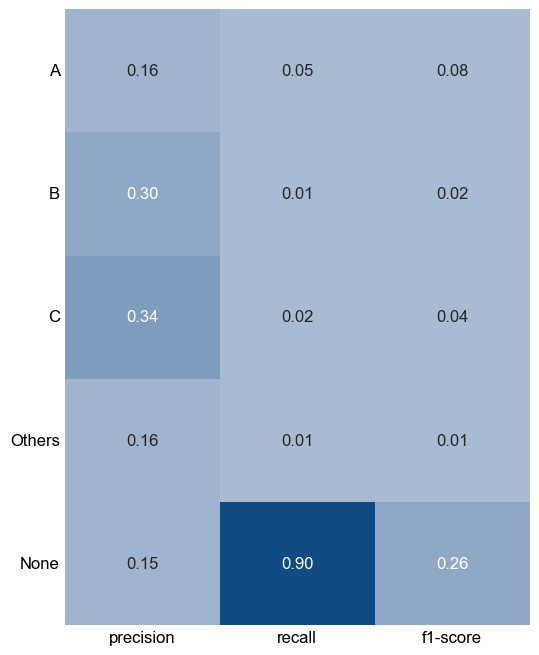

In [41]:
custom_cmap_blues = sns.color_palette(['#A9BBD3', '#A0B4CF', '#8FA8C6', '#7E9CBD', '#6D8FB4', '#537CA6', '#416F9D', '#306294', '#0F4A82'])
custom_cmap_pinks = sns.color_palette(['#FFE6F2', '#FFCCE4', '#F99FC8', '#F28AB9', '#E177A5', '#D56997', '#C85B89', '#B9537E'])

plt.figure(figsize=(6, 8))
sns.heatmap(report_df, annot=True, cmap=custom_cmap_blues, cbar=False, vmin=0, vmax=1,  fmt='.2f',
            annot_kws={"fontfamily": "Arial", "fontsize": 12})
#plt.xlabel('Metrics', labelpad=12, fontname='Arial', fontsize=12)
#plt.title('Classification report', fontname='Arial', fontsize=14, y=1.02)
plt.xticks(fontname='Arial', fontsize=12)
plt.yticks(fontname='Arial', fontsize=12, rotation=0)
plt.tick_params(axis='y', length=0)
plt.tick_params(axis='x', length=0)
plt.show()

Threshold based predictions: binary

In [42]:
results_binary = results

In [43]:
results_binary

,Text,Label_Text,Label_Name,Label_True,Score,Predict
0,• articl of the act stipul that the violat of ...,regul sometim limit choic avail to consum for ...,Others,B,0.620997,None
1,• articl of the act stipul that the violat of ...,regul can affect supplier behaviour by not onl...,C,B,0.599725,None
2,• articl of the act stipul that the violat of ...,regul can affect a supplier 's abil to compet ...,B,B,0.601265,None
3,• articl of the act stipul that the violat of ...,limit the number of supplier lead to the risk ...,A,B,0.752252,A
4,articl of the act stipul that a breach of thi ...,regul sometim limit choic avail to consum for ...,Others,B,0.529027,None
...,...,...,...,...,...,...
13775,establish subject to thi norm i.e those that m...,limit the number of supplier lead to the risk ...,A,A,0.527197,None
13776,the minimum number of pilotag run per semest c...,regul sometim limit choic avail to consum for ...,Others,A,0.602872,None
13777,the minimum number of pilotag run per semest c...,regul can affect supplier behaviour by not onl...,C,A,0.527284,None
13778,the minimum number of pilotag run per semest c...,regul can affect a supplier 's abil to compet ...,B,A,0.515223,None


In [44]:
results_max_score = results_binary.groupby('Text')['Score'].max()

In [45]:
results_final = pd.merge(results_binary, results_max_score, on=['Text', 'Score'])

In [46]:
results_final['Predict'] = np.where(results_final['Score'] > 0.60, 'Yes', 'None')
results_final['Label_True'] = np.where(results_final['Label_True'] == 'None', results_final['Label_True'], 'Yes')

In [47]:
results_final

,Text,Label_Text,Label_Name,Label_True,Score,Predict
0,• articl of the act stipul that the violat of ...,limit the number of supplier lead to the risk ...,A,Yes,0.752252,Yes
1,articl of the act stipul that a breach of thi ...,limit the number of supplier lead to the risk ...,A,Yes,0.647846,Yes
2,articl of the act state that the violat of thi...,limit the number of supplier lead to the risk ...,A,Yes,0.680944,Yes
3,accord to articl of the act an infring of thi ...,limit the number of supplier lead to the risk ...,A,Yes,0.668809,Yes
4,articl of the law state that an infring of thi...,limit the number of supplier lead to the risk ...,A,Yes,0.629033,Yes
...,...,...,...,...,...,...
3400,the respons parti that pay the indemn is exone...,limit the number of supplier lead to the risk ...,A,None,0.660084,Yes
3401,duti period limit for flight and cabin crew of...,limit the number of supplier lead to the risk ...,A,Yes,0.508737,None
3402,the norm specif state that it is not in line w...,regul can affect supplier behaviour by not onl...,C,Yes,0.568243,None
3403,establish subject to thi norm i.e those that m...,regul sometim limit choic avail to consum for ...,Others,Yes,0.573974,None


In [48]:
report = classification_report(results_final['Label_True'], results_final['Predict'])
print(report)

              precision    recall  f1-score   support

        None       0.14      0.51      0.21       521
         Yes       0.82      0.42      0.55      2884

    accuracy                           0.43      3405
   macro avg       0.48      0.46      0.38      3405
weighted avg       0.72      0.43      0.50      3405



### B. Off Shelf SBERT

In [10]:
# initialize model 
word_embedding_model = models.Transformer('bert-base-uncased')
pooling_model = models.Pooling(word_embedding_model.get_word_embedding_dimension(), 'mean')
model_off_shelf = SentenceTransformer(modules=[word_embedding_model, pooling_model])

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [13]:
results_os = calculate_sim_scores(test_list, defs_list, defs_name, labels_list, model_off_shelf).drop_duplicates()

In [129]:
results_multiclass = results_os 
results_os['Predict'] = np.where(results_os['Score'] > 0.60, results_os['Label_Name'], 'None')

In [130]:
# Generate the classification report
report = classification_report(results_os['Label_True'], results_os['Predict'])
print(report)

              precision    recall  f1-score   support

           A       0.36      0.25      0.29      1652
           B       0.07      0.25      0.10       308
           C       0.01      0.25      0.02        52
           D       0.00      0.25      0.00         4
        None       0.64      0.01      0.03      2640

    accuracy                           0.11      4656
   macro avg       0.22      0.20      0.09      4656
weighted avg       0.49      0.11      0.13      4656

